### Notebook to find the HP used in the GP initialization given checkerboard data.

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import os
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

In [2]:
def circular_gaussian(xdata_tuple, x0, y0, sigma, amplitude, offset):
    (x, y) = xdata_tuple
    return offset + amplitude * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))


def map_range(x, old_min, old_max, new_min, new_max):
    return new_min + (x - old_min) * (new_max - new_min) / (old_max - old_min)

In [3]:
def find_parameters(sta, Display, npixels):
    
    image = abs(sta) # take the absolute value to avoid problems related to polarity of rf

    # Fix initial guess for the gaussian center
    
    ## Apply thresholding on the STA
    threshold = np.mean(image) + 2 * np.std(image)
    thr_idxs = image > threshold
    thr_image = np.zeros((np.shape(image)[0], np.shape(image)[1]))
    thr_image[thr_idxs] = image[thr_idxs]
    
    ## Delete border pixels because they will never contain the rf center, according to the geometry of the MEA experiment (I am not sure I can do this) 
    thr_image[:,0:2] = 0
    thr_image[:,-3:-1] = 0
    thr_image[0:2,:] = 0
    thr_image[-3:-1,:] = 0

    #thr_image = median_filter(thr_image, size=2)

    ## Apply a gaussian filter to smooth out the image
    filtered_image = gaussian_filter(thr_image, sigma=1)
    
    ## Take the maximum value of the thresholded and filtered image
    max_image_filt = np.argmax(filtered_image)
    max_coords_filt = np.unravel_index(max_image_filt, filtered_image.shape)
    

    # Use this maximum as initial guess for the gaussian center
    initial_guess = (max_coords_filt[1], max_coords_filt[0], 2, np.max(image), np.min(image))
    bounds = (
        (0, 0, 1, 0, 0),  # Lower bounds     # for (x0, y0, sigma, amplitude, offset)
        (image.shape[1], image.shape[0], np.inf, np.inf, np.inf)  # Upper bounds
    )

    x = np.linspace(0, image.shape[1] - 1, image.shape[1])
    y = np.linspace(0, image.shape[0] - 1, image.shape[0])
    x, y = np.meshgrid(x, y)

    # Flatten the data for curve_fit
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = image.ravel()

    # Perform the fit ON THE ORIGINAL STA (the filtered one is only used to initialise the center of the gaussian)
    popt, pcov = curve_fit(circular_gaussian, xdata, ydata, p0=initial_guess, bounds=bounds)
    # Generate fitted data
    data_fitted = circular_gaussian(xdata, *popt).reshape(image.shape[0], image.shape[1])
    
    # Save parameters
    #parameters = {}
    #parameters['popt'] = popt
    #parameters['pcov'] = pcov
    #parameters['data_fitted'] = data_fitted
    
    hp = {}
    hp['x0'] = map_range(popt[0], 0, npixels, -1, 1)
    hp['y0'] = map_range(popt[1], 0, npixels, -1, 1)
    hp['sigma'] = map_range(popt[2], 0, npixels, -1, 1) 
    
    if Display == True:
        # Plot results
        plt.figure(figsize=(10, 5))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(abs(sta))
        plt.title("Original Image")

        # Plot fitted Gaussian
        plt.subplot(1, 3, 2)
        plt.imshow(filtered_image)
        plt.title('Filtered image')
        plt.scatter(max_coords_filt[1], max_coords_filt[0], color='red', s=30, marker="x", label='Maximum')
        leg = plt.legend()

        # Plot fitted Gaussian
        plt.subplot(1, 3, 3)
        plt.imshow(data_fitted)
        plt.title('Fitted Gaussian')
    
    return hp


#### Upload the dataset of STAs obtained from checkerboards for the experiment

In [4]:

Spatial = scipy.io.loadmat('../data/Data_WN/reformatted_Matlab_output/Spatial.mat')
print(f"Dataset is organised in: {Spatial.keys()}")
STAs = Spatial['Spatial']

print(f"The collected STAs are for 173 cells, the good ones of the experiment according to the sorting: {STAs.shape}")

Dataset is organised in: dict_keys(['__header__', '__version__', '__globals__', 'Spatial'])
The collected STAs are for 173 cells, the good ones of the experiment according to the sorting: (60, 60, 173)


Of these 173 cells, only 41 are good cells according to their STA. 

These are the idx of the good cells in the matlab file, they have then been saved in this order in the file : "  Data/data2_41mixed_tr28.pkl ".

So cell 4 here is cell 0 in the " one_cell_active_training ", and " active_training_likelihood_test " notebooks


(60, 60)

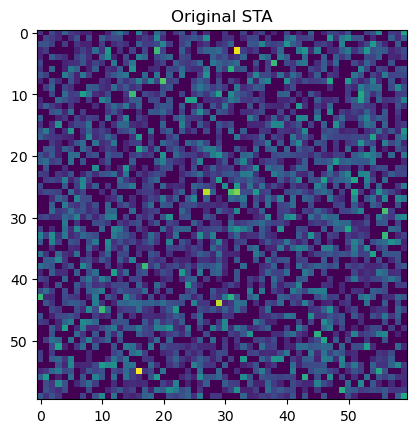

In [7]:
idx_matlab = [4, 5, 8, 10, 11, 14, 24, 38, 43, 44, 48, 49, 52, 54, 
                55, 66, 71, 72, 76, 88, 93, 99, 102, 104, 110, 112, 
                    120, 121, 128, 132, 143, 144, 152, 154, 156, 159, 
                        160, 162, 167, 169, 170]

sta = STAs[:,:,4]
sta = abs(sta)

plt.title("Original STA")
plt.imshow(sta)

### Obtain gaussian fit parameters using the STA

To do so, we use the curve_fit from scipy.optimize.curve_fit which minimizes the square difference of a gaussian to the data.

To give an initial guess of the Gaussian parameters, we use the max of a filtered STA as center of the receptive field. 

Cell 5 - Parameters for the fitted Gaussian:
    x0: 25.189324
    y0: 33.112912
    sigma: 1.125781
    amplitude: 0.837054
    offset: 0.121021


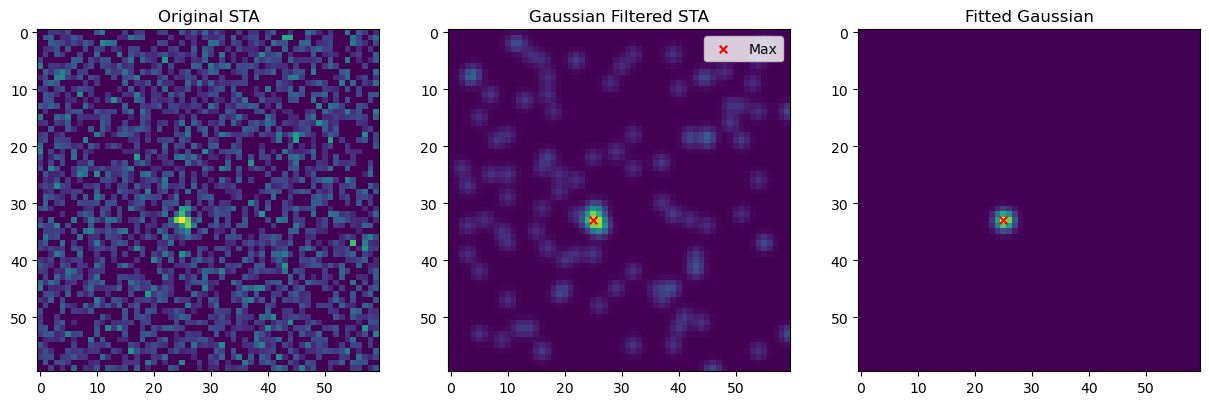

In [6]:
# Lets use cell 5
for i in [5]:
    plt.figure(figsize=(15, 5))
    # region _______ Original STA
    sta = STAs[:,:,i]
    sta = abs(sta)

    plt.subplot(1, 3, 1)
    plt.title("Original STA")
    plt.imshow(sta)
    # endregion

    # region _______ Filter the STA ith a gaussian filter
    # Thresholding on the STA
    threshold = np.mean(sta) + 2 * np.std(sta)
    thr_image = np.where( sta>threshold, sta, 0)
    
    ## Delete border pixels because they will never contain the rf center, according to the geometry of the MEA experiment 
    thr_image[:,0:2] = 0
    thr_image[:,-3:-1] = 0
    thr_image[0:2,:] = 0
    thr_image[-3:-1,:] = 0

    # Apply a gaussian filter to smooth out the image
    filtered_image = gaussian_filter(thr_image, sigma=1)
    # Take the maximum value of the filtered image
    max_image_filt  = np.argmax(filtered_image)
    max_coords_filt = np.unravel_index(max_image_filt, filtered_image.shape)

    plt.subplot(1, 3, 2)
    plt.imshow(filtered_image)
    plt.scatter(max_coords_filt[1], max_coords_filt[0], color='red', s=30, marker="x", label='Max')
    plt.title('Gaussian Filtered STA')
    plt.legend()
    # endregion

    # region _______ Fit a Gaussian on the filtered STA
    # Use this maximum as initial guess for the gaussian center
    def circular_gaussian(xdomain_tuple, x0, y0, sigma, amplitude, offset):
        (x, y) = xdomain_tuple
        return offset + amplitude * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))
    
    # Values for the learned parameters of the circular gaussian: x0, y0, sigma, amplitude, offset
    initial_guess = (max_coords_filt[1], max_coords_filt[0], 2, np.max(sta), np.min(sta))
    bounds = (
        (0, 0, 1, 0, 0),                                      # Lower bounds for (x0, y0, sigma, amplitude, offset)
        (sta.shape[1], sta.shape[0], np.inf, np.inf, np.inf)  # Upper bounds
    )

    # 2D Domain
    x = np.linspace(0, sta.shape[1] - 1, sta.shape[1])
    y = np.linspace(0, sta.shape[0] - 1, sta.shape[0])
    x, y  = np.meshgrid(x, y)
    xdomain = np.vstack((x.ravel(), y.ravel()))

    # Original STA values. Not filtered, filtered one is only used to initialise the center of the gaussian
    ydata = sta.ravel()

    popt, pcov = curve_fit(circular_gaussian, xdomain, ydata, p0=initial_guess, bounds=bounds)
    # Generate fitted data
    data_fitted = circular_gaussian(xdomain, *popt).reshape(sta.shape[0], sta.shape[1])

    plt.subplot(1, 3, 3)
    plt.imshow(data_fitted)
    plt.scatter(max_coords_filt[1], max_coords_filt[0], color='red', s=30, marker="x", label='Max 1st guess')
    plt.title('Fitted Gaussian')

    print(f"Cell {i} - Parameters for the fitted Gaussian:")
    for j, name  in enumerate(['x0', 'y0', 'sigma', 'amplitude', 'offset']):
        print(f"    {name}: {popt[j]:.6f}")
    # endregion

fit_params = popt

### Convert (60 x 60) Hp to (108 x 108 )
The loaded dataset here is of shape 60 x 60, while in the previpous notebooks ( " one_cell_active_training ", and " active_training_likelihood_test " ) the dataset is loaded as 108 x 108.

The learnt parameters are in units of the .shape() of the STA, in this case (60,60).

Convert x0 and y0 of the gaussian from x<sub>60</sub>, y<sub>60</sub> to x<sub>108</sub>, y<sub>108</sub>.

Knowing:

- white noise experiment size: 
    
    60x60 checks x 12 pix/check corresponds to an image of 720x720 projected on the MAE
- natural image experiment size: 

    108x108 x 8 pix/check corresponds to an image of 864x864 projected on the MAE

I can pass from one to the other with this formula (easier to understand with a visual schema of the situation):

x<sub>108</sub> = $ (\frac{x_{60}}{60} \times \frac{720}{8}) + \frac{\frac{864-720}{8}}{2}$

1. $\frac{x_{60}}{60}$  Express the position in the image in absolute terms

2. $\times \frac{720}{8}$  Project it on the new size

3. $ + \frac{\frac{864-720}{8}}{2}$  Add this term to account for the fact that Pietro's image is bigger than mine.

The same holds for the y.


In [17]:
print("Initial hyperparameters")
for j, name  in enumerate(['x0', 'y0', 'sigma', 'amplitude', 'offset']):
    print(f"    {name}: {popt[j]:.6f}")


px_check_wn = 12                      # pixel per check in the white noise experiment
n_checks_wn = 60                      # number of checks in the final image
px_mea_size_wn = px_check_wn*n_checks_wn # size of the image projected ON the MEA - n of pixels

px_check_ni = 8                       # pixel per check in the natural image experiment
n_checks_ni = 108                     # number of "checks" in the final image
px_mea_size_ni = px_check_ni*n_checks_ni # size of the image projected ON the MEA - n of pixels

# size of one pixel projected on the MEA
px_mea = 3.5 # [micron]

def conversion_x1tox2(pos_x1, n_checks_x1, px_mea_size_x1, px_check_x2, px_mea_size_x2,):
    pos_x2 = ((pos_x1/n_checks_x1) * (px_mea_size_x1/px_check_x2)) + (((px_mea_size_x2-px_mea_size_x1)/px_check_x2)/2)
    return pos_x2

# RF center for white noise
x0_wn = fit_params[0]
y0_wn = fit_params[1]

# RF center for natural image
x0_ni = conversion_x1tox2(x0_wn, n_checks_wn, px_mea_size_wn, px_check_ni, px_mea_size_ni)
y0_ni = conversion_x1tox2(y0_wn, n_checks_wn, px_mea_size_wn, px_check_ni, px_mea_size_ni)

print(f"White noise experiment:   x0 = {x0_wn:.2f}, y0 = {y0_wn:.2f}")
print(f"Natural image experiment: x0 = {x0_ni:.2f}, y0 = {y0_ni:.2f}")

# Standard deviation conversion
sigma_wn = fit_params[2]
sigma_ni = (sigma_wn/n_checks_wn) * (px_mea_size_wn/px_check_ni)
print(f"\nWhite noise experiment:   sigma = {sigma_wn:.5f}, sigma2 = {sigma_wn*sigma_wn:.5f} pixels ")
print(f"Natural image experiment: sigma = {sigma_ni:.5f}, sigma2 = {sigma_ni*sigma_ni:.5f} pixels")

# MISSING CONVERSION TO MICRONS



Initial hyperparameters
    x0: 25.189324
    y0: 33.112912
    sigma: 1.125781
    amplitude: 0.837054
    offset: 0.121021
White noise experiment:   x0 = 25.19, y0 = 33.11
Natural image experiment: x0 = 46.78, y0 = 58.67

White noise experiment:   sigma = 1.12578, sigma2 = 1.26738 pixels 
Natural image experiment: sigma = 1.68867, sigma2 = 2.85161 pixels


#### Let's check wether the converted parameters correspond to the ones that we get from the Natural Images